In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os

In [3]:
path = '/home/nessa/tensorflow_datasets/fake_lens/10000_image_param_cstr'

### load and prepare the data

In [342]:
def prep_data(max_n, bit_size,filename_stem, filename_ending, skip_first=True, delim=None, add_noise=True, keep_sparse=True):
    data = np.zeros((1000,bit_size*max_n))*np.nan
    for ii in range(1000):
        for nn, line in enumerate(open(os.path.join(path,filename_stem+"%d"%(ii+1)+filename_ending), "rb")):
            if skip_first:
                if nn>0:
                    item = line.rstrip()
                    new_bit = np.asarray([np.float(num) for num in item.split(delim)])
                    data[ii][(nn-1)*bit_size:(nn)*bit_size] = new_bit
            else:
                item = line.rstrip()
                new_bit = np.asarray([np.float(num) for num in item.split(delim)])
                data[ii][nn*bit_size:(nn+1)*bit_size] = new_bit
                
    flat_data = np.reshape(data,(-1,bit_size))
    means     = np.nanmean(flat_data,axis=0)
    print(means)
    non_info_index = []
    discrete = np.zeros((bit_size))
    for ii in range(bit_size):
        length = len(np.unique(flat_data[:,ii][~np.isnan(flat_data[:,ii])].flatten()))
        if length==1:
            print(ii)
            non_info_index.append(ii)
        if length<200:
            discrete[ii]=1
        else:
            _ = plt.hist(flat_data[:,ii], bins=100)
            plt.axvline(means[ii],color='orange')
            plt.show()
    discrete = np.delete(discrete, non_info_index)
    
    bit_size= bit_size - len(non_info_index)
    data = np.tile(np.delete(means,non_info_index,0),max_n)
    data = np.tile(data,1000)
    if keep_sparse:
        data = np.zeros((1000, bit_size*max_n))
    else:
        np.reshape(data,[1000,-1])

    for ii in range(1000):
        for nn, line in enumerate(open(os.path.join(path,filename_stem+"%d"%(ii+1)+filename_ending), "rb")):
            if skip_first:
                if nn>0:
                    item = line.rstrip()
                    new_bit = np.asarray([np.float(num) for num in item.split(delim)])
                    new_bit = np.delete(new_bit,non_info_index,0)
                    noise   = np.random.randn(len(new_bit))*0.1
                    noise*=discrete
                    if add_noise:
                        new_bit+=noise
                    data[ii][(nn-1)*bit_size:(nn)*bit_size] = new_bit
            else:
                item = line.rstrip()
                new_bit = np.asarray([np.float(num) for num in item.split(delim)])
                new_bit = np.delete(new_bit,non_info_index,0)
                noise   = np.random.randn(len(new_bit))*0.1
                noise*=discrete
                if add_noise:
                    new_bit+=noise
                data[ii][nn*bit_size:(nn+1)*bit_size] = new_bit
    
    flat_data_2 = np.reshape(data,(-1,bit_size))
    for ii in range(bit_size):
        _ = plt.hist(flat_data_2[:,ii], bins=100, density=True)
        _ = plt.hist(np.delete(flat_data,non_info_index,axis=1)[:,ii], bins=100, density=True)
        plt.axvline(np.delete(means, non_info_index)[ii],color='orange')
        plt.show()
    
    return data

[3.94535858e+00 9.31387768e-03 4.92083204e-02 1.00000000e-01
 1.00000000e-01 0.00000000e+00 3.47787954e+00 2.34450481e+01]
3
4
5


/home/nessa/miniconda3/envs/AKDE/lib/python3.7/site-packages/numpy/lib/histograms.py:829: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/nessa/miniconda3/envs/AKDE/lib/python3.7/site-packages/numpy/lib/histograms.py:830: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


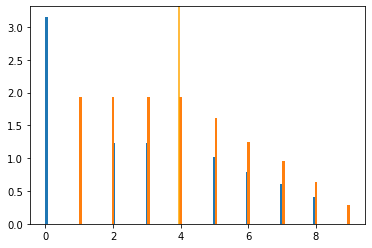

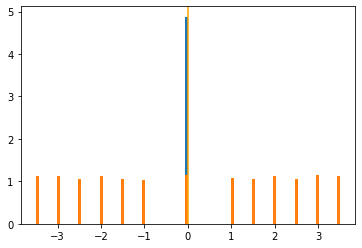

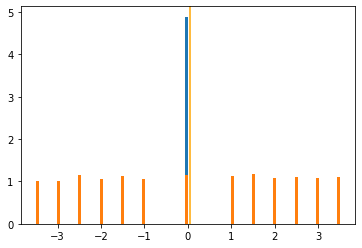

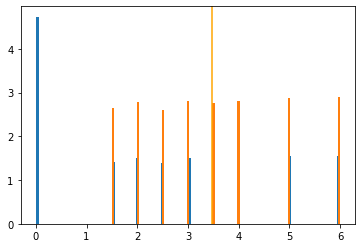

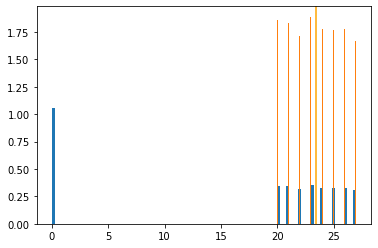

In [343]:
source_data = prep_data(9,8,"gal_source/gal_source_",'.dat', add_noise=False)

[ 3.97792154  0.31546382 -0.20345005  0.42643004  0.1338848  79.01959563
  3.52569885 22.10929076]


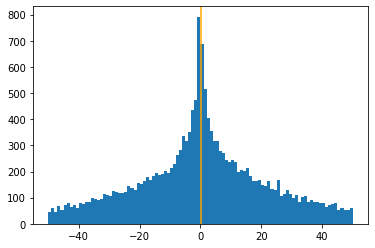

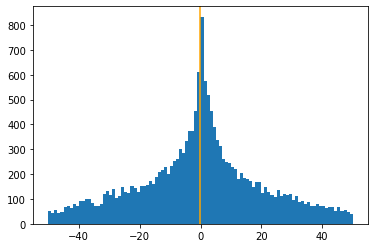

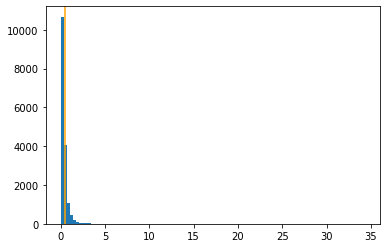

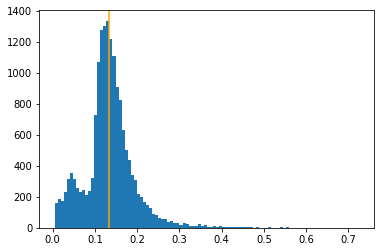

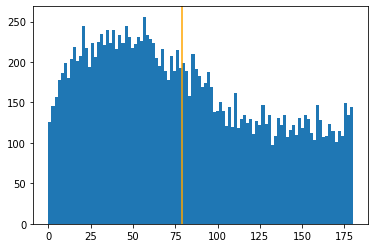

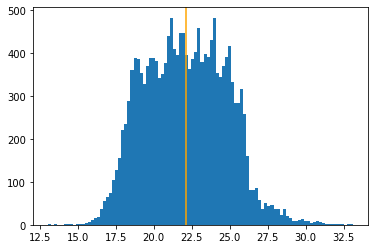

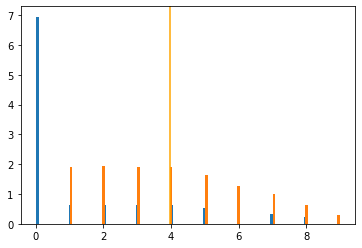

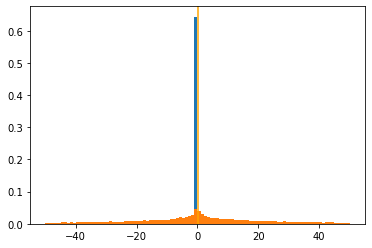

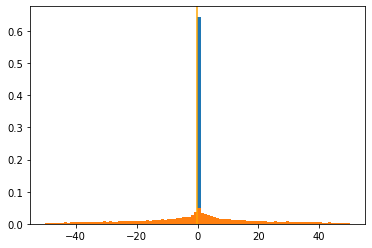

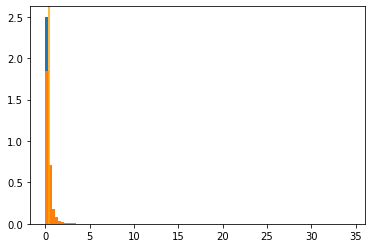

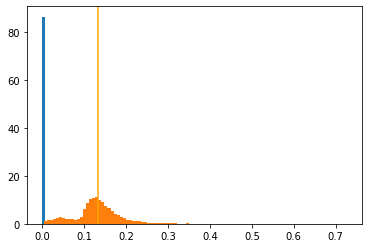

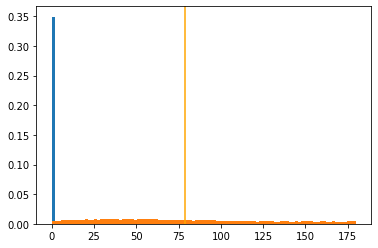

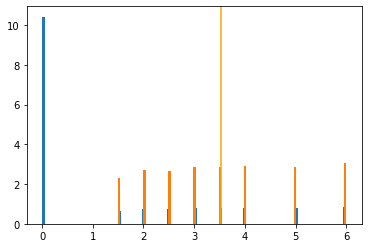

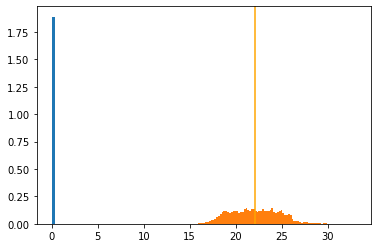

In [344]:
image_data  = prep_data(45,8,"image/image_",'.all', add_noise=False)

In [345]:
### why are params discrete?

[7.6000e-02 6.1000e-02 4.1000e-01 4.9870e+01 1.0002e+02 1.2979e+03
 1.1930e+03 5.0000e-01 5.0000e-01 1.5000e-01 1.8992e+01 1.2617e+02
 3.9750e+01]
7
8
9


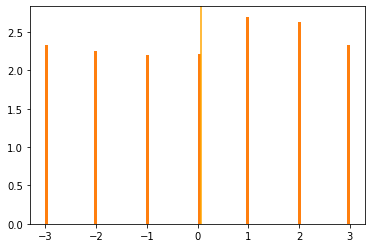

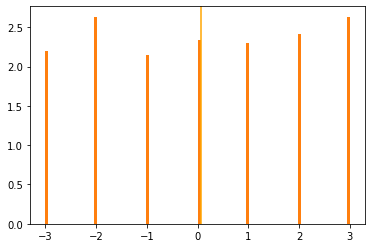

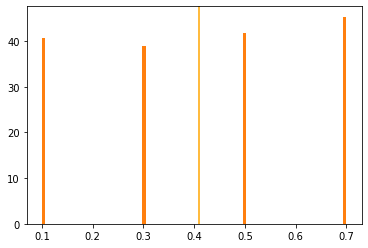

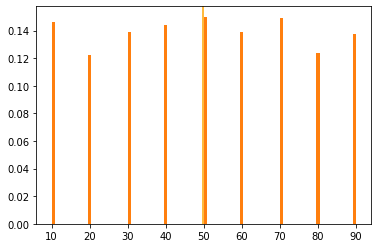

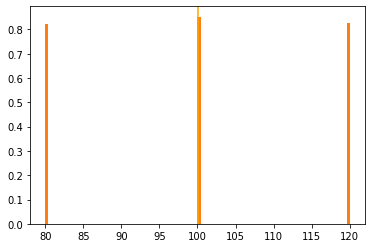

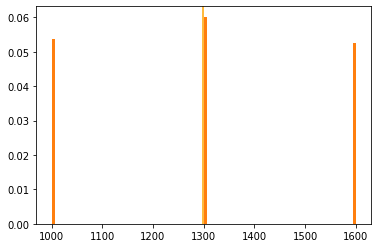

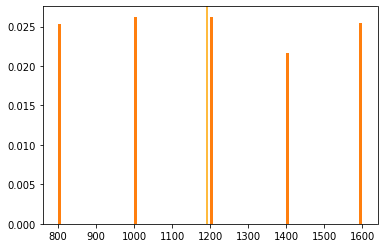

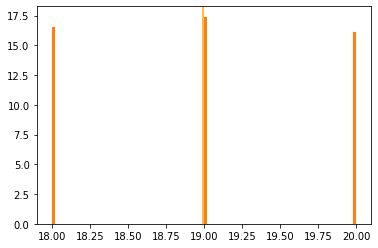

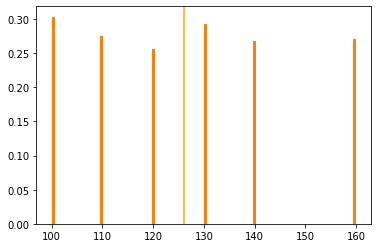

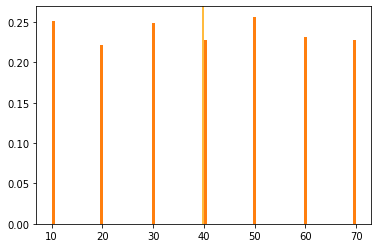

In [346]:
params  = prep_data(1,13,"param/param_",'.txt', add_noise=False,delim=b',', skip_first=False )

[ 1.29378846e+04 -6.03954335e-02  3.97834873e+01  4.49132715e-01
  3.12809180e-01  5.56726923e+00  2.16065635e+01  0.00000000e+00]


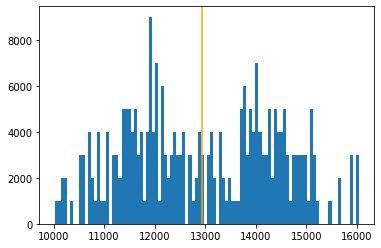

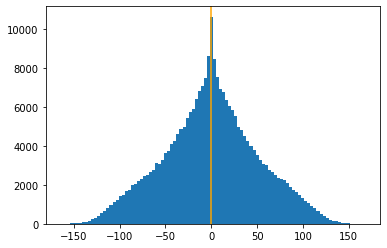

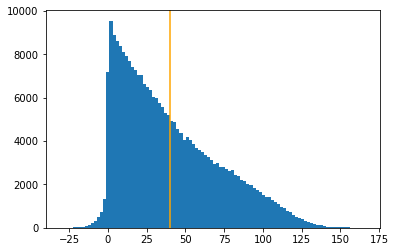

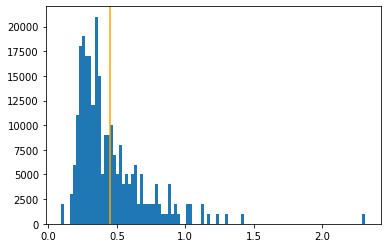

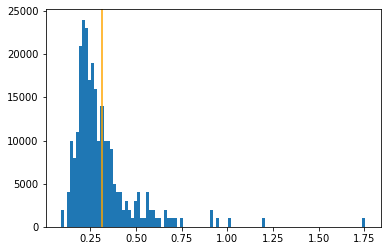

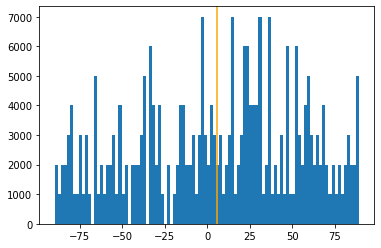

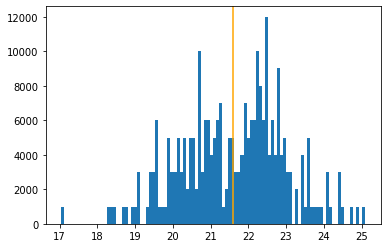

7


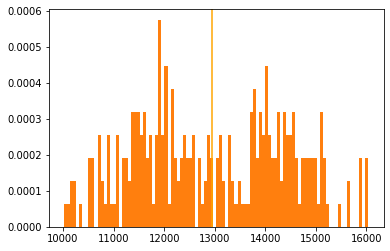

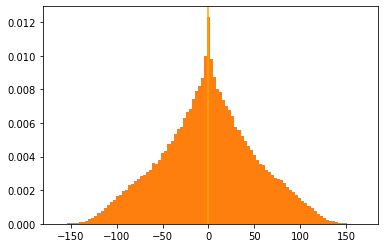

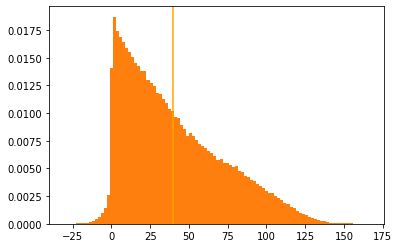

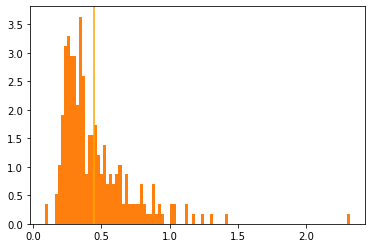

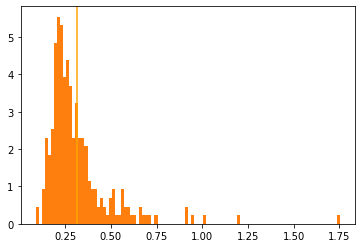

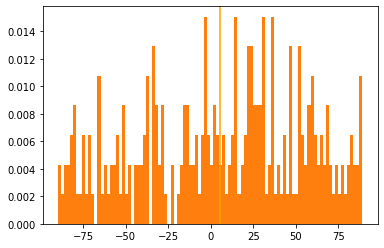

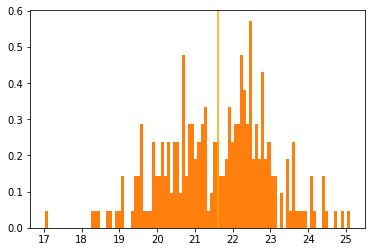

In [347]:
galcat_data  = prep_data(260,8,"galcat/galcat_",'.cat', add_noise = False, delim=None, skip_first=True )

In [348]:
# x and y of dm potential
# ellipticity
# position angle degrees
# core radius
#f.write(x_centre+","+y_centre+","+ellipticite+","+angle_pos+","+core_radius_kpc+","+cut_radius_kpc+","+v_disp+","+z_lens+","+zlens+","+corekpc+","+mag0+","+sigma+","+cutkpc+"\n") 


### just concatenating data and labels and encoding labels

In [622]:
X = np.concatenate((source_data, image_data), axis=1)
Y = params

In [631]:
from sklearn.decomposition import PCA

In [636]:
pca=PCA(n_components=100)

In [637]:
pca.fit(X)

PCA(copy=True, iterated_power='auto', n_components=100, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

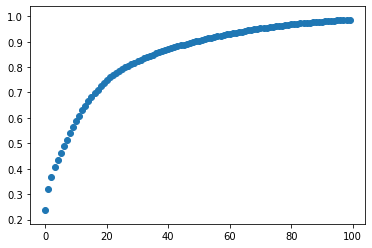

In [638]:
plt.scatter(np.arange(pca.n_components_),np.cumsum(pca.explained_variance_ratio_))

In [639]:
X = pca.transform(X)

In [640]:
from sklearn.preprocessing import OrdinalEncoder
enc = OrdinalEncoder()
enc.fit(Y)
enc.categories_

[array([-3., -2., -1.,  0.,  1.,  2.,  3.]),
 array([-3., -2., -1.,  0.,  1.,  2.,  3.]),
 array([0.1, 0.3, 0.5, 0.7]),
 array([10., 20., 30., 40., 50., 60., 70., 80., 90.]),
 array([ 80., 100., 120.]),
 array([1000., 1300., 1600.]),
 array([ 800., 1000., 1200., 1400., 1600.]),
 array([18., 19., 20.]),
 array([100., 110., 120., 130., 140., 160.]),
 array([10., 20., 30., 40., 50., 60., 70.])]

In [641]:
class_Y = enc.transform(Y)

In [642]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_regression
from sklearn.metrics import accuracy_score
from sklearn.multioutput import MultiOutputClassifier

In [643]:
({'estimator__bootstrap': False,
  'estimator__criterion': 'entropy',
  'estimator__max_depth': 5,
  'estimator__max_features': 'sqrt',
  'estimator__min_samples_leaf': 2,
  'estimator__min_samples_split': 5,
  'estimator__n_estimators': 50},
 0.0)

({'estimator__bootstrap': False,
  'estimator__criterion': 'entropy',
  'estimator__max_depth': 5,
  'estimator__max_features': 'sqrt',
  'estimator__min_samples_leaf': 2,
  'estimator__min_samples_split': 5,
  'estimator__n_estimators': 50},
 0.0)

In [673]:
N = 500

In [674]:
regr = RandomForestClassifier(n_estimators=50,max_depth=20,random_state=0,min_samples_split=10,min_samples_leaf=4,criterion='entropy', max_features='sqrt', bootstrap=False)
regr= MultiOutputClassifier(regr)
regr.fit(X[:N], class_Y[:N])

MultiOutputClassifier(estimator=RandomForestClassifier(bootstrap=False,
                                                       class_weight=None,
                                                       criterion='entropy',
                                                       max_depth=20,
                                                       max_features='sqrt',
                                                       max_leaf_nodes=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=4,
                                                       min_samples_split=10,
                                                       min_weight_fraction_leaf=0.0,
                                                       n_estimators=50,
                                                       n_jobs=None,
                  

In [675]:
regr.score(X[N:],class_Y[N:])

0.0

In [676]:
valid_predict = regr.predict(X)

In [677]:
for ii in range(10):
    print(accuracy_score(valid_predict[:N,ii], class_Y[:N, ii]),accuracy_score(valid_predict[N:,ii], class_Y[N:, ii]))

1.0 0.162
1.0 0.208
1.0 0.348
1.0 0.126
1.0 0.334
1.0 0.356
0.996 0.508
1.0 0.342
1.0 0.166
1.0 0.134


In [680]:
accuracies =[]
for ii in range(10):
    accuracies.append(accuracy_score(valid_predict[N:,ii], class_Y[N:, ii]))
np.mean(accuracies)

0.26839999999999997

In [681]:
class_Y[500:][0], valid_predict[0]

(array([2., 1., 2., 1., 0., 2., 2., 1., 1., 0.]),
 array([2., 0., 0., 7., 1., 0., 3., 2., 2., 0.]))

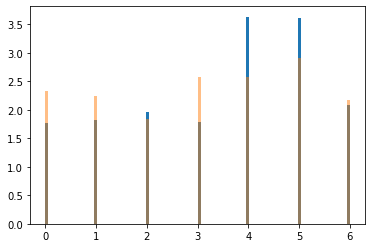

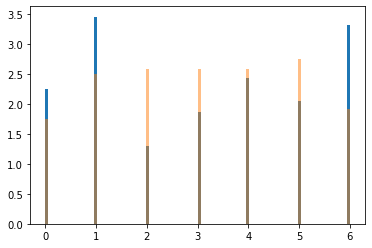

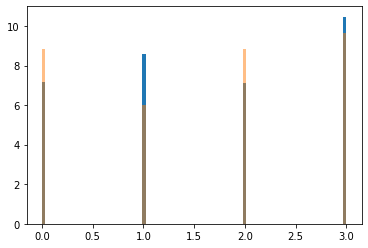

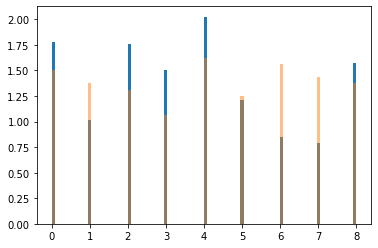

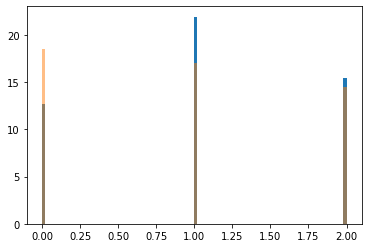

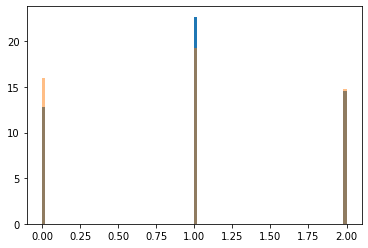

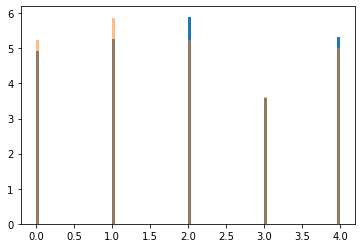

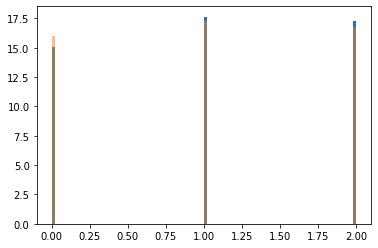

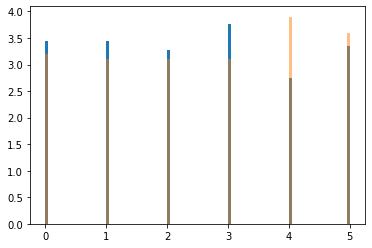

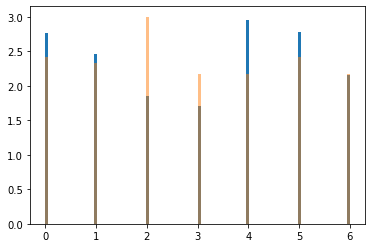

In [682]:
for ii in range(valid_predict.shape[-1]):
    _ = plt.hist(valid_predict[:,ii],bins=100, density=True)
    _ = plt.hist(class_Y[800:,ii], bins=100, density=True, alpha=0.5)
    plt.show()

In [648]:
from sklearn.model_selection import RandomizedSearchCV# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 100, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
criteria =['gini', 'entropy']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5, 55, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [2, 4, 5]
# Method of selecting samples for training each tree
bootstrap = [True, False]# Create the random grid
random_grid = {'estimator__n_estimators': n_estimators,
               'estimator__max_features': max_features,
               'estimator__max_depth': max_depth,
               'estimator__min_samples_split': min_samples_split,
               'estimator__min_samples_leaf': min_samples_leaf,
               'estimator__bootstrap': bootstrap,
               'estimator__criterion': criteria}
print(random_grid)

{'estimator__n_estimators': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100], 'estimator__max_features': ['auto', 'sqrt'], 'estimator__max_depth': [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, None], 'estimator__min_samples_split': [2, 5, 10], 'estimator__min_samples_leaf': [2, 4, 5], 'estimator__bootstrap': [True, False], 'estimator__criterion': ['gini', 'entropy']}


In [553]:
from sklearn.model_selection import ShuffleSplit

cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=0)

In [649]:
rf = RandomForestClassifier()
rf = MultiOutputClassifier(rf)
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = cv, verbose=2, random_state=42, n_jobs = -1)# Fit the random search model
rf_random.fit(X[:900], class_Y[:900])

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   21.2s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  7.4min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 10.2min finished


RandomizedSearchCV(cv=ShuffleSplit(n_splits=5, random_state=0, test_size=0.3, train_size=None),
                   error_score='raise-deprecating',
                   estimator=MultiOutputClassifier(estimator=RandomForestClassifier(bootstrap=True,
                                                                                    class_weight=None,
                                                                                    criterion='gini',
                                                                                    max_depth=None,
                                                                                    max_features='auto',
                                                                                    max_leaf_nodes=None,
                                                                                    min_impurity_decrease=0.0,
                                                                                    min_impurity_split=None,
                 

In [651]:
rf_random.best_params_

{'estimator__n_estimators': 60,
 'estimator__min_samples_split': 10,
 'estimator__min_samples_leaf': 4,
 'estimator__max_features': 'sqrt',
 'estimator__max_depth': 10,
 'estimator__criterion': 'entropy',
 'estimator__bootstrap': False}

In [652]:
rf_random.refit

True

In [656]:
rf_random.best_estimator_.score(X[900:],class_Y[900:]), rf_random.best_estimator_.score(X[:900],class_Y[:900])

(0.0, 0.91)

In [657]:
accuracies =[]
for ii in range(10):
    accuracies.append(accuracy_score(valid_predict[900:,ii], class_Y[900:, ii]))
np.mean(accuracies)

0.278

In [658]:
from sklearn.model_selection import GridSearchCV# Create the parameter grid based on the results of random search 
param_grid = {
    'estimator__bootstrap': [True],
    'estimator__max_depth': [5,10,15],
    'estimator__max_features': ['sqrt'],
    'estimator__min_samples_leaf': [2, 4, 6],
    'estimator__min_samples_split': [5, 10, 15],
    'estimator__n_estimators': [50,60,70],
    'estimator__criterion': ['entropy']}
# Create a based model
rf = RandomForestClassifier()
rf = MultiOutputClassifier(rf)
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 8, n_jobs = -1, verbose = 2)

In [659]:
grid_search.fit(X[:800], class_Y[:800])

Fitting 8 folds for each of 81 candidates, totalling 648 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


KeyboardInterrupt: 

In [546]:
grid_search.best_params_, grid_search.best_score_

({'estimator__bootstrap': False,
  'estimator__criterion': 'entropy',
  'estimator__max_depth': 5,
  'estimator__max_features': 'sqrt',
  'estimator__min_samples_leaf': 2,
  'estimator__min_samples_split': 5,
  'estimator__n_estimators': 50},
 0.0)

In [547]:
grid_search.best_estimator_.score(X[800:],class_Y[800:]), grid_search.best_estimator_.score(X[:800],class_Y[:800])

(0.0, 0.5575)

In [548]:
valid_predict = grid_search.best_estimator_.predict_proba(X[800:])
# accuracies =[]
# for ii in range(10):
#     accuracies.append(accuracy_score(valid_predict[:,ii], class_Y[800:, ii]))
# np.mean(accuracies)

In [442]:
class_Y[:800].shape

(800, 10)

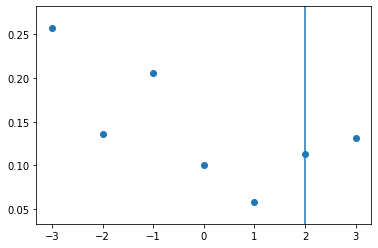

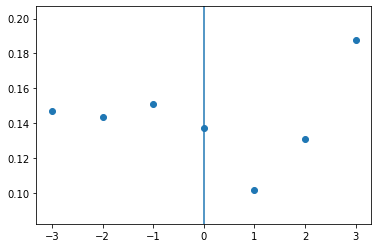

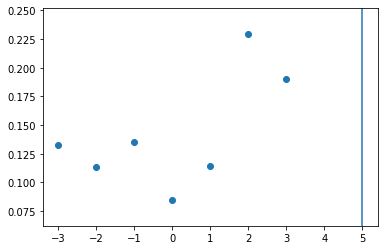

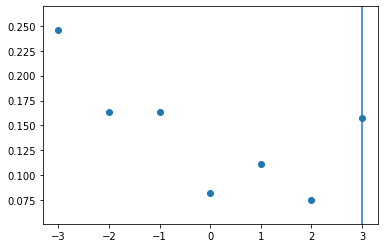

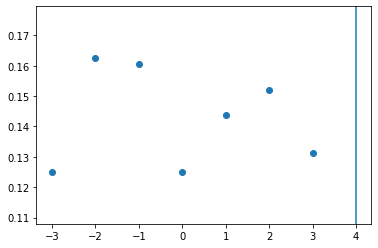

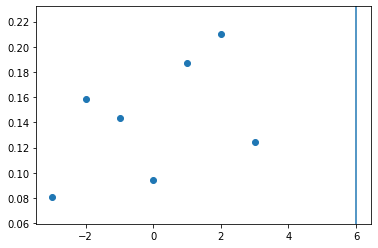

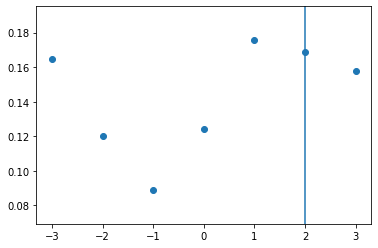

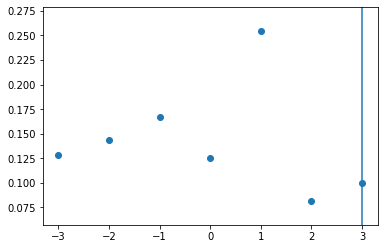

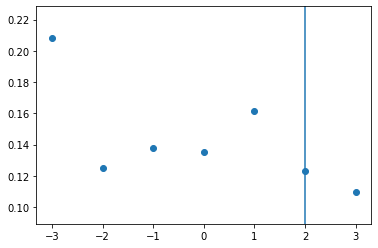

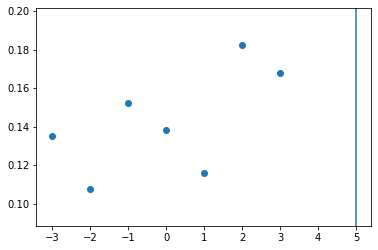

In [443]:
valid_predict[0].shape
for ii in range(10):
    plt.scatter(enc.categories_[0],valid_predict[0][ii])
    plt.axvline(class_Y[:800][ii,0])
    plt.show()

In [23]:
# lenstool input files
filename = os.path.join(path,'pylenstool_model_9944.par')
for line in open(filename, "rb"):
    item = line.rstrip()
    print(item)


b'#pylenstool modification 20210422041655'
b'runmode'
b'\treference\t3 0.0 0.0'
b'\tsource\t1 gal_source_9944.dat'
b'\tend'
b'grille'
b'\tnombre\t128'
b'\tpolaire\t0'
b'\tnlentille\t261'
b'\tend'
b'image'
b'\tnewton\t1'
b'\tend'
b'potentiel\tDM1'
b'\tprofil\t81'
b'\tx_centre\t1'
b'\ty_centre\t2'
b'\tellipticite\t0.7'
b'\tangle_pos\t40'
b'\tcore_radius_kpc\t120'
b'\tcut_radius_kpc\t1000'
b'\tv_disp\t1400'
b'\tz_lens\t0.5'
b'\tend'
b'potfile'
b'\tfilein\t1 new_galcat.txt'
b'\tzlens\t0.5'
b'\ttype\t81'
b'\tcorekpc\t0.15'
b'\tmag0\t20.0'
b'\tsigma\t0 110 0.0'
b'\tcutkpc\t0 60 0.0'
b'\tslope\t0 4.000000 4.200000'
b'\tvdslope\t0 4.000000 0.000000'
b'\tvdscatter\t0 0.000000 0.000000'
b'\trcutscatter\t0 0.000000 0.000000'
b'\tend'
b'cline'
b'\tnplan\t0'
b'\tdmax\t0.000000'
b'\talgorithm\tMARCHINGSQUARES'
b'\tlimitHigh\t10.0'
b'\tlimitLow\t1.000000'
b'\tend'
b'grande'
b'\tiso\t0 0 1.000000 0.000000 0.000000'
b'\tname\tbest'
b'\tprofil\t0 0'
b'\tcontour\t0 0'
b'\tlarge_dist\t2.000000'
b'\tend'
b